In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from numpy.random import default_rng
rng = default_rng()

In [3]:
from pathlib import Path

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
from scipy.optimize import bisect

In [6]:
from simulation_functions import simulate_and_calculate_n_times, simulate_and_calculate_pl
from simulation_parameters import sample_params
from graphing_utils import graph_pl

In [7]:
from data_cleaning_utils import clean_imported_df

In [8]:
from metrics_extraction import calculate_metrics

In [9]:
params = sample_params()

In [21]:
params = {'upfront_fee': 0.02,
 'upfront_hours': 15.0,  # ???
 'monthly_opened_streams': 1226.5440930055968,
 'average_stream_lifetime': 42.33821634933179,
 'percent_accidently_liquidated_per_month': 2.27286899729628,
 'average_stream_size': 443.3675311964653,
 'refund_rate': 0.7142343592538698,  # ???
 'min_self_liquidation_savings': 38.320143281465604,
 'gas_prediction_ability': 0.7558234710515153,
 'lowest_stream_cost_ratio': 2.0042413609539036,
 'distribution_inverse_skewness': 2.7152632742190743}

In [85]:
# solve for amount of margin to get desired decentralization w/ sufficient frequency

In [10]:
df = clean_imported_df(pd.read_csv('input_data.csv'))

In [11]:
params = sample_params()

In [13]:
# def optimize(params):
#     refund_rate = .5
#     previous_step_size = .02
#     error = 1
#     gradient = None
#     for i in range(10):
#         error, der = calculate_and_return_loss(refund_rate, params)
        
    

In [73]:
sign = lambda x: (1, -1)[x<0]

In [56]:
def calculate_and_return_loss(refund_rate, params):
    params['refund_rate'] = refund_rate
    local_df = simulate_and_calculate_pl(df, params)
    metrics = calculate_metrics(local_df, params)
    return metrics['liquidator_md_percent'] - metrics['liquidator_percent_of_profit']
    # return diff**2

In [40]:
def get_der(refund_rate, params):
    params['refund_rate'] = refund_rate
    local_df = simulate_and_calculate_pl(df, params)
    metrics = calculate_metrics(local_df, params)
    diff = metrics['liquidator_relative_md'] - metrics['gas_tank_relative_md']
    return 2*diff

In [34]:
params=sample_params()

In [68]:
params['upfront_fee'] = .3

In [54]:
params

{'upfront_fee': 0.01,
 'upfront_hours': 16,
 'monthly_opened_streams': 1291.499389819841,
 'average_stream_lifetime': 38.52509409273822,
 'percent_accidently_liquidated_per_month': 0.26254887169392044,
 'average_stream_size': 494.22011914010466,
 'refund_rate': 0.98,
 'min_self_liquidation_savings': 31.62113406686215,
 'gas_prediction_ability': 0,
 'lowest_stream_cost_ratio': 3.8403230398672568,
 'distribution_inverse_skewness': 4.599849751166942}

In [52]:
losses = []
for i in range(50):
    losses.append(calculate_and_return_loss(i/50, params))

In [38]:
bisect(calculate_and_return_loss, .001, .999, args=params)

0.49614839852500514

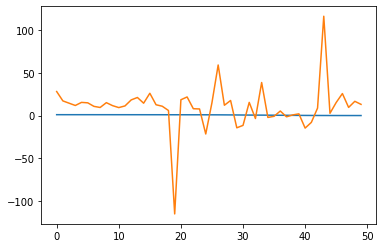

In [53]:
plt.plot(losses)

In [57]:
params=sample_params()

In [41]:
# cases interested in...
fees = [.01, .025, .04]
margins = [1, 2, 4, 8, 16]

In [48]:
params

{'upfront_fee': 0.01,
 'upfront_hours': 16,
 'monthly_opened_streams': 1291.499389819841,
 'average_stream_lifetime': 38.52509409273822,
 'percent_accidently_liquidated_per_month': 0.26254887169392044,
 'average_stream_size': 494.22011914010466,
 'refund_rate': 0.9999,
 'min_self_liquidation_savings': 31.62113406686215,
 'gas_prediction_ability': 0,
 'lowest_stream_cost_ratio': 3.8403230398672568,
 'distribution_inverse_skewness': 4.599849751166942}

In [57]:
results = []
failed_params = []
for fee in fees:
    for margin in margins:
        for i in range(10):
            params = sample_params()
            params['upfront_fee'] = fee
            params['upfront_hours'] = margin
            params['gas_prediction_ability'] = 0
            try:
                params['refund_rate'] = bisect(calculate_and_return_loss, .00001, .99999, args=params)
            except:
                failed_params.append(params)
                params['refund_rate'] = 0
            
            local_df = simulate_and_calculate_pl(df, params)
            metrics = calculate_metrics(local_df, params)
            results.append({**params, **metrics})
            print('-',end='')

------------------------------------------------------------------------------------------------------------------------------------------------------

In [58]:
r = pd.DataFrame(results)

In [62]:
# r.to_csv('first_big_result.csv')

In [72]:
subset = r.loc[r['upfront_fee'] == .025]

In [70]:
subset.loc[subset['total_profit'] > 0].shape[0] / subset.shape[0]

0.48

In [74]:
subset[['upfront_hours', 'percent_self_closed']].groupby('upfront_hours').mean()

,percent_self_closed
upfront_hours,
1,0.002198
2,0.005591
4,0.060608
8,0.121670
16,0.184927


In [75]:
r[['upfront_hours', 'percent_self_closed']].groupby('upfront_hours').mean()

,percent_self_closed
upfront_hours,
1,0.005730
2,0.007744
4,0.050633
8,0.096576
16,0.295015


In [76]:
subset[['upfront_hours', 'refund_rate']].groupby('upfront_hours').mean()

,refund_rate
upfront_hours,
1,0.983187
2,0.965923
4,0.894776
8,0.897524
16,0.773460


In [77]:
subset = r.loc[r['upfront_fee'] == .01]

In [78]:
subset[['upfront_hours', 'refund_rate']].groupby('upfront_hours').mean()

,refund_rate
upfront_hours,
1,0.945158
2,0.906211
4,0.739094
8,0.753801
16,0.642283


In [81]:
subset = r.loc[r['upfront_fee'] == .04]

In [82]:
subset[['upfront_hours', 'refund_rate']].groupby('upfront_hours').mean()

,refund_rate
upfront_hours,
1,0.971355
2,0.961001
4,0.927864
8,0.945679
16,0.821700


In [89]:
subset[['upfront_hours', 'refund_rate']].groupby('upfront_hours').mean()

,refund_rate
upfront_hours,
1,0.971355
2,0.961001
4,0.927864
8,0.945679
16,0.821700


In [22]:
r['realized_profit'] = r['gas_tank_realized_pl'] + r['liquidator_pl']

In [67]:
r

,upfront_fee,upfront_hours,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,distribution_inverse_skewness,liquidator_md,gas_tank_md,liquidator_md_percent,liquidator_percent_of_profit,total_profit,n_opened,percent_self_closed,percent_closed,total_margin_taken
0,0.01,1,180.041513,46.228576,0.345246,375.281224,0.984297,9.673770,0,1.968257,2.445276,160.326547,9213.120272,0.017104,0.017564,-7.576547e+03,987.0,0.000000,0.778116,3.121628e+05
1,0.01,1,563.438582,19.960269,23.505509,1513.580639,0.933263,40.288367,0,2.347020,4.965491,4021.991732,57536.978034,0.065336,0.066359,-5.658973e+04,3489.0,0.000000,0.902264,4.775578e+06
2,0.01,1,269.460403,181.334510,1.826947,800.901852,0.980385,6.527615,0,3.776591,1.391680,64.960204,4370.691047,0.014645,0.015714,1.236770e+04,1388.0,0.000000,0.391210,5.194597e+05
3,0.01,1,1029.208220,6.889982,0.338753,417.502817,0.979574,39.315701,0,3.079994,4.509381,1746.214491,101409.000049,0.016928,0.016932,-1.000417e+05,5454.0,0.000000,0.969930,2.356458e+06
4,0.01,1,164.823833,200.763843,0.248140,2407.125743,0.966910,15.828128,0,1.637204,3.170992,49.548711,1166.988367,0.040729,0.067675,1.139299e+04,1025.0,0.000000,0.378537,9.627858e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.04,16,164.725032,96.424980,4.037056,1965.881028,0.832025,49.735988,0,3.687121,1.968356,200.952377,1471.286735,0.120170,0.161839,9.444809e+04,986.0,0.121479,0.576065,8.792753e+05
146,0.04,16,622.941970,37.782390,0.216525,9223.512148,0.777154,27.287102,0,3.494945,3.478693,216.473338,2215.118764,0.089025,0.055011,3.802619e+05,3888.0,0.898916,0.806584,1.385441e+06
147,0.04,16,1567.382295,56.199224,54.520496,605.051691,0.890837,37.576515,0,2.621129,1.612741,1930.957161,15617.288555,0.110037,0.112412,6.247646e+05,8393.0,0.003076,0.852258,4.819104e+06
148,0.04,16,1461.570775,57.024602,0.826479,198.657535,0.964431,8.539035,0,1.267337,3.287156,393.637769,14525.908691,0.026384,0.029824,5.815885e+05,7852.0,0.001077,0.709373,1.179175e+06


In [20]:
r.loc[r['upfront_fee'] == .025]

,upfront_fee,upfront_hours,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,...,gas_tank_md_time,gas_tank_eth_pl,gas_tank_usd_pl,percent_self_closed,n_opened,percent_closed,total_margin_taken,gas_tank_realized_pl,liquidator_md_ratio,percent_pl_to_liquidator
5,0.025,1,5479.999677,200.639737,11.434761,541.658876,0.997334,36.927535,0,2.475798,...,4835,542.091766,1.245420e+06,0.000000,31909.0,0.501833,8.978469e+06,269984.484542,0.055661,0.037660
6,0.025,2,840.423051,17.345490,1.672745,1586.500329,0.967226,7.637918,0,3.292639,...,19640,45.176795,9.842042e+04,0.000426,5179.0,0.906932,7.469860e+06,68394.494774,0.197247,0.161288
7,0.025,4,2922.771726,5.572458,0.882769,249.838134,0.988265,45.200548,0,2.341939,...,65936,116.623279,2.645598e+05,0.000000,13591.0,0.980355,3.813348e+06,248371.929942,0.057997,0.055312
8,0.025,8,923.744150,47.059200,26.946751,3264.122500,0.781111,26.758114,0,3.454944,...,5819,80.999415,1.874116e+05,0.151155,5750.0,0.820348,1.186280e+07,123262.301216,0.430645,0.406042
9,0.025,16,404.013206,4.414833,4.154603,5454.476655,0.815401,15.094517,0,0.939048,...,4104,48.809371,1.182306e+05,0.832794,2521.0,0.979770,1.359050e+06,115046.302110,0.253846,0.156420


In [182]:
results = []
for i in range(10):
    params = sample_params()
    params['upfront_hours'] = 4
    params['upfront_fee'] = .01
    params['gas_prediction_ability'] = 0
    params['refund_rate'] = bisect(calculate_and_return_loss, 0, 1, args=params)
    
    local_df = simulate_and_calculate_pl(df, params)
    metrics = calculate_metrics(local_df, params)
    results.append({**params, **metrics})

In [183]:
pd.DataFrame(results)

,upfront_fee,upfront_hours,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,...,gas_tank_md_time,gas_tank_eth_pl,gas_tank_usd_pl,percent_self_closed,n_opened,percent_closed,total_margin_taken,gas_tank_realized_pl,liquidator_md_ratio,percent_pl_to_liquidator
0,0.01,4,1316.324102,197.615186,4.638540,5141.359177,0.559876,49.083317,0,2.260998,...,8048,51.963003,119182.906983,0.023363,8209.0,0.422341,1.678237e+07,1124.204487,0.915835,0.958955
1,0.01,4,2486.876255,3.349836,7.257877,3442.849846,0.601009,16.284242,0,1.100144,...,115802,-24.688366,-65782.808661,0.074449,15524.0,0.981190,4.538584e+07,-73043.910507,0.398567,0.395562
2,0.01,4,554.046064,5.249975,0.201174,6874.871251,0.485017,42.574084,0,3.151078,...,107774,3.743291,7230.262793,0.133112,3426.0,0.967017,1.615087e+07,4428.461569,0.417584,0.619466
3,0.01,4,255.131143,120.518165,0.285386,579.421333,0.563721,17.265230,0,2.332357,...,7137,7.346341,14806.032960,0.000000,1499.0,0.527685,4.852673e+05,-2370.545494,1.086786,0.855111
4,0.01,4,3217.930724,5.151395,0.418807,154.972844,0.935623,4.140856,0,3.979767,...,116566,-6.388127,-28132.487634,0.000000,8000.0,0.995250,1.702820e+06,-29030.535565,0.232543,0.158896
5,0.01,4,1376.673827,107.516585,0.488869,5699.655761,0.539043,44.887049,0,1.732482,...,4177,48.129051,107141.507544,0.079904,8589.0,0.531843,2.111789e+07,7542.671664,0.927412,0.781734
6,0.01,4,1703.026710,14.789891,18.550323,344.298794,0.400311,5.651476,0,2.983045,...,99506,28.849773,60779.004467,0.000000,8517.0,0.939533,2.956571e+06,48290.361413,1.332793,1.314316
7,0.01,4,943.709874,3.728830,2.314207,1517.174185,0.693781,35.644457,0,2.461644,...,117569,-15.588790,-39254.214480,0.002902,5259.0,0.982886,8.483495e+06,-41464.755293,0.382567,0.396196
8,0.01,4,3094.475535,21.079038,2.648809,214.989486,0.455887,48.532408,0,2.353294,...,98672,38.199563,74223.075710,0.000000,11221.0,0.900633,3.118925e+06,47416.233843,1.289250,1.281146
9,0.01,4,328.898470,71.607142,8.995922,1857.046407,0.519547,27.473374,0,3.871169,...,22323,6.954484,13066.048291,0.000698,2011.0,0.712581,2.734790e+06,-1152.457520,1.246581,0.941272


In [ ]:
# given 

In [93]:
result['x']

array([0.975])

In [105]:
params['refund_rate'] = .8

In [106]:
df = simulate_and_calculate_pl(df, params)
metrics = calculate_metrics(df, params)
graph_pl(df)

In [ ]:
# given 

In [5]:
# read in the output
files = [str(f) for f in Path('./third_run').glob('**/*') if '.csv' in str(f)]

In [6]:
outputs = []
for f in files:
    outputs.append(pd.read_csv(f).drop(columns=['Unnamed: 0']))

In [7]:
df = pd.concat(outputs).reset_index(drop=True)

In [95]:
df = clean_imported_df(pd.read_csv('input_data.csv'))

In [96]:
df = simulate_and_calculate_n_times(df, 500)

In [97]:
df

,upfront_fee,upfront_hours,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,...,gas_tank_md_time,gas_tank_eth_pl,gas_tank_usd_pl,percent_self_closed,n_opened,percent_closed,total_margin_taken,gas_tank_realized_pl,liquidator_md_ratio,percent_pl_to_liquidator
0,0.022361,5.0,306.317946,4.901677,7.028990,768.874787,0.677882,27.985634,0.613490,2.516853,...,5231.0,22.436129,5.502520e+04,0.000000,1847.0,0.978343,1.411812e+06,5.281246e+04,1.032908,-0.325866
1,0.050000,0.0,9248.463666,221.879084,6.447941,210.703684,0.853853,42.144631,1.561646,3.866527,...,7666.0,1357.296721,3.188186e+06,0.000000,29055.0,0.389640,3.354176e+06,1.075595e+06,1.004011,-0.046120
2,0.050000,0.0,289.572059,97.035529,15.156310,647.434161,0.630383,23.133032,0.626163,2.972258,...,4070.0,65.133850,1.565497e+05,0.000000,1457.0,0.665752,7.360341e+05,9.712946e+04,1.003424,-0.149064
3,0.050000,0.0,8909.960730,21.585222,1.669386,5511.529453,0.620721,35.788961,1.862764,0.929394,...,156.0,2348.684516,5.794016e+06,0.000000,55596.0,0.885765,2.704748e+08,5.003173e+06,1.000605,-0.157259
4,0.050000,0.0,1541.282980,22.281823,0.339589,250.123190,0.183277,40.510679,0.909421,3.190341,...,4385.0,285.088341,6.846959e+05,0.000000,5927.0,0.891176,1.664940e+06,6.069402e+05,1.001304,-0.279853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.010000,10.0,1011.093434,11.839066,48.608631,634.133354,0.224906,11.902839,0.356031,1.722850,...,6628.0,37.467498,9.054347e+04,0.024228,5686.0,0.950932,3.444851e+06,8.367709e+04,1.019279,3.214247
496,0.022361,5.0,449.435670,6.764599,13.012829,4464.551637,0.715683,45.507957,1.954801,2.723123,...,7613.0,32.480825,8.062274e+04,0.021715,2804.0,0.968973,1.162315e+07,7.580075e+04,0.484338,0.388641
497,0.010000,10.0,818.413284,15.782793,19.279900,3156.748393,0.277856,46.936536,1.768225,3.216376,...,4177.0,33.500108,8.121725e+04,0.105620,5088.0,0.926690,1.210886e+07,7.200000e+04,0.962566,0.387223
498,0.002000,20.0,150.157262,13.808508,6.636714,2185.785291,0.247301,29.246729,1.176783,1.651301,...,101563.0,-0.416658,-1.401931e+03,0.416764,936.0,0.917735,8.388469e+05,-1.784516e+03,-0.243536,1.708236


In [104]:
np.mean(df.loc[df['upfront_hours'] == 20, 'percent_self_closed'])

0.3345151905864296

In [35]:
df.columns

Index(['upfront_fee', 'upfront_hours', 'monthly_opened_streams',
       'average_stream_lifetime', 'percent_accidently_liquidated_per_month',
       'average_stream_size', 'refund_rate', 'min_self_liquidation_savings',
       'gas_prediction_ability', 'lowest_stream_cost_ratio',
       'distribution_inverse_skewness', 'liquidator_md', 'liquidator_md_time',
       'liquidator_pl', 'gas_tank_md', 'gas_tank_md_time', 'gas_tank_eth_pl',
       'gas_tank_usd_pl', 'n_streams_self_closed', 'n_streams_liquidated',
       'percent_self_closed', 'gas_refunded_eth', 'gas_refunded_usd',
       'n_opened', 'opening_fees_usd', 'total_margin_taken', 'efficiency'],
      dtype='object')

In [ ]:
# miminize price incurred per transaction....

In [36]:
df['perc_closed'] = (df['n_streams_self_closed'] + df['n_streams_liquidated']) / df['n_opened']

In [37]:
# profit / user fees paid
df['efficiency'] = (df['opening_fees_usd']*df['perc_closed'] + df['liquidator_pl'] - df['gas_refunded_usd'] / df['refund_rate']) / (
    df['opening_fees_usd']*df['perc_closed'] + df['total_margin_taken'])

In [ ]:
# profit / fees spent on gas


In [63]:
group = df.loc[df['upfront_hours'] == 20].reset_index(drop=True)

In [64]:
# want to calculate everything for a group...
np.mean(group['efficiency'])

-0.037000261702661866

In [20]:
group2 = df.loc[df['upfront_hours'] == 10].reset_index(drop=True)

In [22]:
group3 = df.loc[df['upfront_hours'] == 0].reset_index(drop=True)

In [24]:
group4 = df.loc[df['upfront_hours'] == 5].reset_index(drop=True)

In [21]:
np.mean(group2['total_pl'])

132715.02618612538

In [23]:
np.mean(group3['total_pl'])

1070980.2911679472

In [24]:
group2.columns

NameError: name 'group2' is not defined

In [25]:
np.mean(group4['total_pl'])

429077.5529065287

In [ ]:
# want to look at profit margins
# profit vs money from users

In [16]:
group.columns

Index(['upfront_fee', 'upfront_hours', 'monthly_opened_streams',
       'average_stream_lifetime', 'percent_accidently_liquidated_per_month',
       'average_stream_size', 'refund_rate', 'min_self_liquidation_savings',
       'gas_prediction_ability', 'lowest_stream_cost_ratio',
       'distribution_inverse_skewness', 'liquidator_md', 'liquidator_md_time',
       'liquidator_pl', 'gas_tank_md', 'gas_tank_md_time', 'gas_tank_eth_pl',
       'gas_tank_usd_pl', 'n_streams_self_closed', 'percent_self_closed',
       'total_pl'],
      dtype='object')

In [19]:
np.mean(group['total_pl'])

-21635.771769064184

In [22]:
df['gas_tank_md'] = df['gas_tank_md'] / df['average_stream_size']
df['liquidator_md'] = df['liquidator_md'] / df['average_stream_size']

In [24]:
df['total_pl'] = df['liquidator_pl'] + df['gas_tank_eth_pl']*2500

<AxesSubplot:>

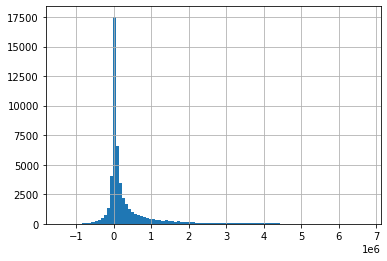

In [29]:
df['total_pl'].hist(bins=100)

In [30]:
subset = df.loc[(df['liquidator_pl'] > 0) & 
                (df['gas_tank_eth_pl'] > 0) & 
                (df['total_pl'] > 50000) & 
                (df['liquidator_md_time'] < (60*24*7)) & 
                (df['gas_tank_md_time'] < (60*24*14)) & 
                (df['percent_self_closed'] > .2)].reset_index(drop=True)

In [31]:
df.columns

Index(['upfront_fee', 'upfront_hours', 'monthly_opened_streams',
       'average_stream_lifetime', 'percent_accidently_liquidated_per_month',
       'average_stream_size', 'refund_rate', 'min_self_liquidation_savings',
       'gas_prediction_ability', 'lowest_stream_cost_ratio',
       'distribution_inverse_skewness', 'liquidator_md', 'liquidator_md_time',
       'liquidator_pl', 'gas_tank_md', 'gas_tank_md_time', 'gas_tank_eth_pl',
       'gas_tank_usd_pl', 'n_streams_self_closed', 'percent_self_closed',
       'total_pl'],
      dtype='object')

In [26]:
subset = group

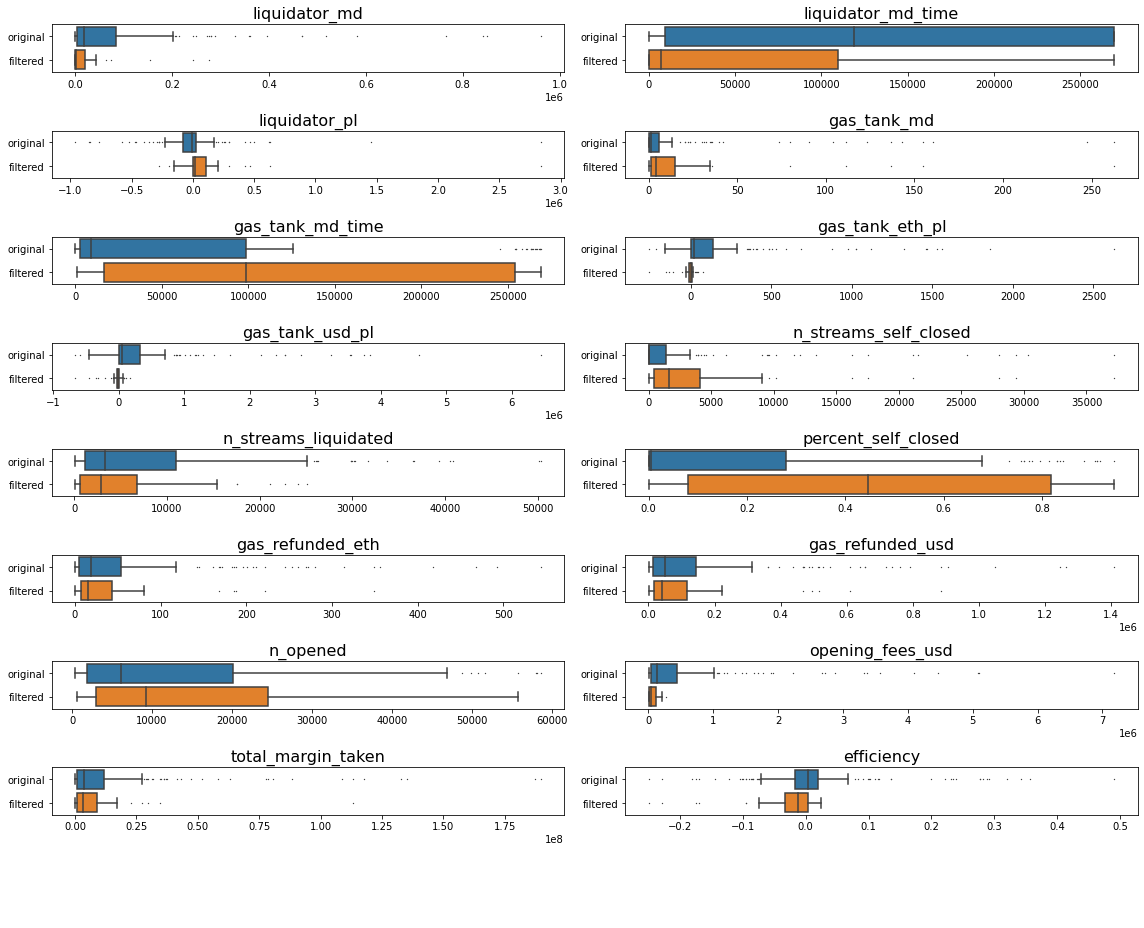

In [33]:
# compare original and filtered groups
cols = list(df.columns)[-16:]
fig, axs = plt.subplots(len(cols) // 2 + 1, 2, figsize=(16, 13))

for i, ax in enumerate(axs.flat):
    if i >= len(cols):
        ax.axis('off')
        continue
        
    col = cols[i]
    local_df = df[[col]].stack().reset_index().drop(columns=['level_0'])
    local_df.columns = [col, 'value']
    local_df['group'] = 'original'
    
    local_subset = subset[[col]].stack().reset_index().drop(columns=['level_0'])
    local_subset.columns = [col, 'value']
    local_subset['group'] = 'filtered'
    
    joint_df = pd.concat([local_df, local_subset]).reset_index(drop=True)
    sns.boxplot(x='value', y='group', data = joint_df, ax=ax, fliersize=.5)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(col, fontsize=16)
    
plt.tight_layout()

In [155]:
subset

,upfront_fee,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,upfront_hours,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,liquidator_md,liquidator_md_time,liquidator_pl,gas_tank_md,gas_tank_md_time,gas_tank_eth_pl,n_streams_self_closed,percent_self_closed
0,0.044611,7547.407295,106.305120,15.515453,5728.070275,19.531335,0.217807,13.908527,1.608824,2.433518,2.092344,3482.0,1.393980e+06,0.000015,11.0,2058.467809,17864.0,0.576760
1,0.013026,8342.033983,37.901495,27.062362,5172.038973,9.178602,0.679838,19.769731,1.354303,0.884315,1.165211,3713.0,9.655126e+05,0.003591,9284.0,359.446336,18393.0,0.415623
2,0.012917,1178.418960,110.594677,35.358430,8152.761181,18.696346,0.585341,39.180470,1.434962,1.559350,0.005279,64.0,6.210389e+05,0.000107,2481.0,66.691259,2192.0,0.396240
3,0.048343,2951.274680,149.403593,0.672461,9514.251834,16.690563,0.326845,29.222657,1.040170,3.549750,0.092133,2641.0,7.067754e+04,0.000009,12.0,883.584637,7225.0,0.895957
4,0.049690,929.500954,78.982172,49.709174,5866.236373,9.580671,0.641919,7.849013,1.708320,3.757714,0.087177,2063.0,1.834452e+05,0.000079,401.0,255.205005,1523.0,0.321173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322681,0.024805,551.004807,18.600187,59.457180,6472.139633,7.932924,0.746013,22.742835,1.797986,1.510346,0.024694,401.0,9.381396e+04,0.000150,4257.0,58.238358,1231.0,0.386014
322682,0.010048,3776.726902,170.641072,12.326352,5562.083469,11.945071,0.723502,15.444814,0.277444,1.597423,0.041942,320.0,4.902310e+05,0.000946,6530.0,146.654588,5916.0,0.457611
322683,0.013694,9250.205606,84.641488,23.488883,6186.425684,11.764587,0.288385,8.698235,1.744577,1.595419,5.661135,4150.0,1.261379e+06,0.000076,688.0,694.950816,20773.0,0.489491
322684,0.034350,3212.661738,52.801526,54.866866,7429.831014,17.115405,0.022514,12.218989,0.656330,3.579786,2.671352,3815.0,1.133085e+06,0.000003,40.0,685.032977,7894.0,0.461583


In [34]:
cols = df.columns
scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)
df = pd.DataFrame(data=df, columns=cols)

In [35]:
pca = PCA(n_components=7)
pca.fit(df)

PCA(n_components=7)

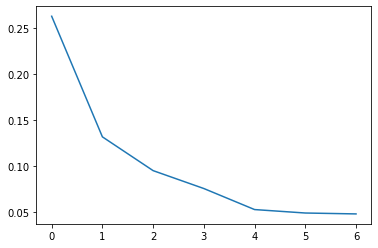

In [36]:
plt.plot(pca.explained_variance_ratio_)

In [37]:
sns.set_style('white')
sns.set_context('notebook')

In [40]:
df.columns

Index(['upfront_fee', 'upfront_hours', 'monthly_opened_streams',
       'average_stream_lifetime', 'percent_accidently_liquidated_per_month',
       'average_stream_size', 'refund_rate', 'min_self_liquidation_savings',
       'gas_prediction_ability', 'lowest_stream_cost_ratio',
       'distribution_inverse_skewness', 'liquidator_md', 'liquidator_md_time',
       'liquidator_pl', 'gas_tank_md', 'gas_tank_md_time', 'gas_tank_eth_pl',
       'gas_tank_usd_pl', 'n_streams_self_closed', 'percent_self_closed',
       'total_pl'],
      dtype='object')

In [41]:
def plot_princ_comp(comps, cols, comp_number=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,12))
    colors = ['input']*11 + ['output']*10
    df = pd.DataFrame(comps, columns=['Component Value'])
    df['metric'] = cols
    df['var type'] = colors
    sns.barplot(x='Component Value', y='metric', hue='var type', data=df, ax=ax, dodge=False)
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='major', labelsize=14)
    if comp_number >= 2:
        ax.set_yticks([])
        ax.legend([],[], frameon=False)
    ax.set_title('Principle Comp {}'.format(comp_number), fontsize=18)

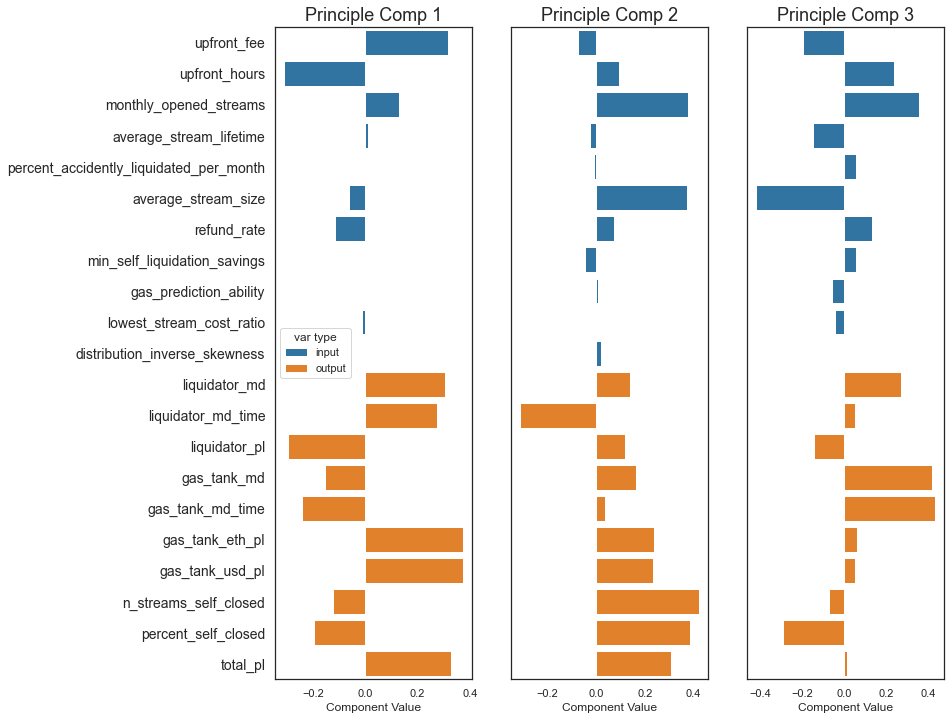

In [42]:
fig, axs = plt.subplots(1,3,figsize=(12,12))
for i, ax in enumerate(axs.flat):
    plot_princ_comp(pca.components_[i], cols, comp_number=i+1, ax=ax)

<AxesSubplot:>

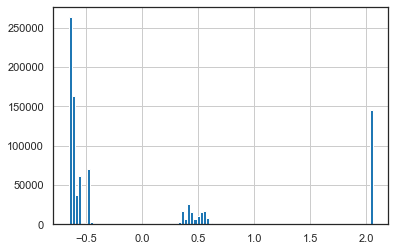

In [149]:
df['liquidator_md_time'].hist(bins=100)

In [150]:
df

,upfront_fee,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,upfront_hours,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,liquidator_md,liquidator_md_time,liquidator_pl,gas_tank_md,gas_tank_md_time,gas_tank_eth_pl,n_streams_self_closed,percent_self_closed
0,-0.292142,-0.522475,0.745188,-1.075864,-1.007504,-1.674193,-1.235019,-1.078262,1.617777,-0.436621,0.248232,2.058168,-0.887149,-0.190741,-0.332807,-0.323366,-0.748991,-1.007333
1,0.836665,-1.440063,1.441326,1.090309,0.101018,-0.837234,-1.038875,1.190736,-0.234118,1.312583,-0.242876,0.373300,-0.536226,-0.191016,-0.325794,-0.728951,-0.736469,-0.919603
2,1.342957,0.873641,-0.282546,-0.844782,0.236750,1.649077,-0.977910,-0.873201,1.052641,0.038167,-0.250372,-0.618922,0.876876,-0.191013,-0.333745,2.170384,1.882585,1.595253
3,0.048177,0.048404,-0.833423,-1.296053,0.429642,-1.030168,1.443929,1.151889,0.632742,1.347416,-0.257862,-0.653356,0.063383,-0.150666,-0.248630,-0.172619,-0.540545,-0.728192
4,-0.935203,1.152034,-1.241617,-0.176239,0.042208,-0.144313,0.623065,-0.449872,0.611774,-1.637832,-0.253705,-0.616598,0.432209,-0.058884,-0.136082,-0.493774,1.960513,0.868135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879995,-0.563618,-0.444499,-0.089511,-1.365562,1.114674,-1.667591,-1.345685,-0.854032,1.663541,-0.288648,-0.105473,2.058078,-0.932282,-0.191388,-0.332786,-0.411437,-0.748991,-1.007333
879996,0.602904,-0.645015,-1.032707,1.433584,0.832157,1.230569,-1.654619,-0.995229,-0.597216,1.278252,-0.248291,-0.615572,0.606117,-0.191468,-0.333127,0.016764,0.413888,1.075526
879997,0.328399,-1.283607,0.697765,0.753631,0.516698,-1.288946,0.878132,1.575431,-1.036160,-0.424155,-0.255468,-0.560777,-0.483158,-0.187973,-0.253704,-0.753263,-0.747076,-0.998117
879998,-1.005684,-0.896367,0.785641,-0.891357,0.399221,-0.626602,0.281591,-0.526656,0.815672,0.998339,-0.254484,-0.615109,-0.363568,-0.182407,-0.248012,-0.850376,-0.406638,0.187343


In [100]:
subset = df.loc[(df['liquidator_pl'] > 0) & 
                (df['gas_tank_eth_pl'] > 0)].reset_index(drop=True)

In [109]:
subset = scaler.transform(subset) ## same transform as before
subset = pd.DataFrame(data=subset, columns = cols)

In [111]:
boxplot_data = subset.stack().reset_index().drop(columns=['level_0'])
boxplot_data.columns = ['variable', 'value']

<AxesSubplot:xlabel='value', ylabel='variable'>

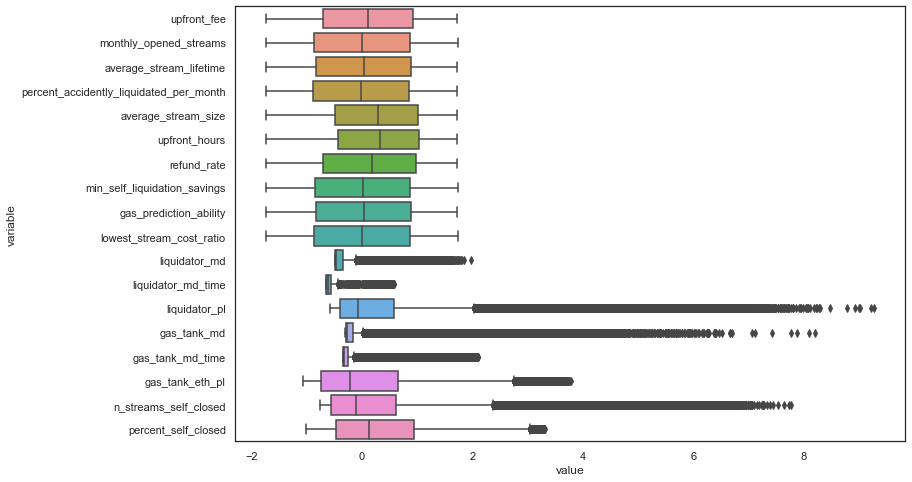

In [112]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x = 'value', y = 'variable', data = boxplot_data, ax=ax)

<AxesSubplot:>

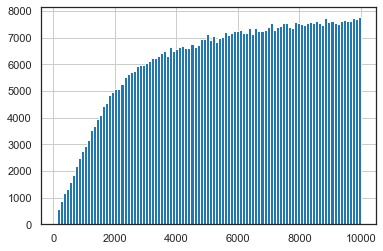

In [101]:
subset['average_stream_size'].hist(bins=100)

In [90]:
subset

,upfront_fee,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,upfront_hours,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,liquidator_md,liquidator_md_time,liquidator_pl,gas_tank_md,gas_tank_md_time,gas_tank_eth_pl,n_streams_self_closed,percent_self_closed
0,0.044611,7547.407295,106.305120,15.515453,5728.070275,19.531335,0.217807,13.908527,1.608824,2.433518,11985.092943,3482.0,1.393980e+06,0.087663,11.0,2058.467809,17864.0,0.576760
1,0.013026,8342.033983,37.901495,27.062362,5172.038973,9.178602,0.679838,19.769731,1.354303,0.884315,6026.517566,3713.0,9.655126e+05,18.575113,9284.0,359.446336,18393.0,0.415623
2,0.041684,9053.764564,160.210005,0.203421,7790.746676,6.353629,0.248582,30.960002,0.578530,2.816891,48497.410949,16686.0,1.083873e+05,0.263056,27.0,2301.719839,11606.0,0.492280
3,0.048343,2951.274680,149.403593,0.672461,9514.251834,16.690563,0.326845,29.222657,1.040170,3.549750,876.581309,2641.0,7.067754e+04,0.087699,12.0,883.584637,7225.0,0.895957
4,0.007730,9647.553351,26.748301,34.547477,5659.219854,17.415538,0.323129,40.293946,1.266044,2.141220,20487.848596,3427.0,1.679514e+06,8.419881,4413.0,328.934075,30597.0,0.571607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175744,0.013143,5425.351556,23.085206,34.006703,5290.820597,17.663016,0.975809,13.476844,1.427864,1.937442,0.000000,0.0,1.082895e+06,31.633165,16463.0,202.340786,20321.0,0.664411
175745,0.017510,4031.572128,213.331099,9.667130,9835.617942,9.197943,0.165254,40.912733,1.518360,0.808263,9230.698170,3846.0,4.901126e+05,0.057132,46.0,425.221272,5391.0,0.448018
175746,0.010048,3776.726902,170.641072,12.326352,5562.083469,11.945071,0.723502,15.444814,0.277444,1.597423,233.282428,320.0,4.902310e+05,5.264191,6530.0,146.654588,5916.0,0.457611
175747,0.013694,9250.205606,84.641488,23.488883,6186.425684,11.764587,0.288385,8.698235,1.744577,1.595419,35022.193843,4150.0,1.261379e+06,0.469260,688.0,694.950816,20773.0,0.489491


In [140]:
subset

,upfront_fee,monthly_opened_streams,average_stream_lifetime,percent_accidently_liquidated_per_month,average_stream_size,upfront_hours,refund_rate,min_self_liquidation_savings,gas_prediction_ability,lowest_stream_cost_ratio,liquidator_md,liquidator_md_time,liquidator_pl,gas_tank_md,gas_tank_md_time,gas_tank_eth_pl,n_streams_self_closed,percent_self_closed
0,0.836665,-1.440063,1.441326,1.090309,0.101018,-0.837234,-1.038875,1.190736,-0.234118,1.312583,-0.363855,0.373300,-0.536226,-0.292754,-0.325794,-0.728951,-0.736469,-0.919603
1,1.342957,0.873641,-0.282546,-0.844782,0.236750,1.649077,-0.977910,-0.873201,1.052641,0.038167,-0.422738,-0.618922,0.876876,-0.292564,-0.333745,2.170384,1.882585,1.595253
2,0.048177,0.048404,-0.833423,-1.296053,0.429642,-1.030168,1.443929,1.151889,0.632742,1.347416,-0.490781,-0.653356,0.063383,-0.087322,-0.248630,-0.172619,-0.540545,-0.728192
3,-0.935203,1.152034,-1.241617,-0.176239,0.042208,-0.144313,0.623065,-0.449872,0.611774,-1.637832,-0.456723,-0.616598,0.432209,0.260103,-0.136082,-0.493774,1.960513,0.868135
4,1.131901,1.401385,0.473241,-1.731317,0.958433,-0.633680,-0.871273,0.358353,-0.731975,0.452917,-0.214485,-0.486095,-0.457324,-0.287321,-0.333404,2.551816,0.960708,1.214043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618475,1.698683,-1.540115,-0.067739,1.420158,0.977812,-0.255500,1.226168,0.905935,0.054291,0.468543,-0.491047,-0.653839,-0.346652,-0.275603,-0.320508,-0.797154,-0.665760,-0.224071
618476,0.602904,-0.645015,-1.032707,1.433584,0.832157,1.230569,-1.654619,-0.995229,-0.597216,1.278252,-0.377892,-0.615572,0.606117,-0.294519,-0.333127,0.016764,0.413888,1.075526
618477,0.328399,-1.283607,0.697765,0.753631,0.516698,-1.288946,0.878132,1.575431,-1.036160,-0.424155,-0.465970,-0.560777,-0.483158,-0.276139,-0.253704,-0.753263,-0.747076,-0.998117
618478,-1.005684,-0.896367,0.785641,-0.891357,0.399221,-0.626602,0.281591,-0.526656,0.815672,0.998339,-0.457594,-0.615109,-0.363568,-0.249232,-0.248012,-0.850376,-0.406638,0.187343


In [ ]:
# define output range, look at inputs
desired_output_range = {'liquidator_pl': []}

In [ ]:
# mean is gamma * theta... so 
# skewness is 2 / sqrt(theta) so 

In [138]:
GAMMA_K = .8
theta = 1000 / GAMMA_K
stream_sizes = rng.gamma(GAMMA_K, theta, size=1000)

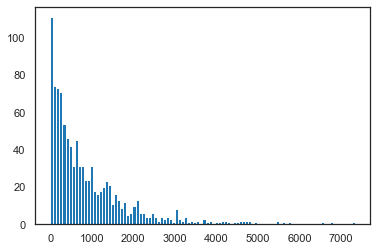

In [139]:
plt.hist(stream_sizes, bins=100) # quantify distriubtion skewness
plt.show()